# DISTANZA DI Hausdorff con Mask_RCNN
Nel seguente modulo useremo la distanza di Hausdorff per misurare quanto due insieme sono "vicini" tra loro.

In [2]:
# COMMON LIBRARIES
import os
import cv2
import requests
import json
import numpy as np
import torch
import random

import matplotlib.pyplot as plt
from datetime import datetime

from scipy.spatial.distance import cdist

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

In [3]:
# Percorsi ai file COCO
base_path = os.getcwd()

# Costruisci i percorsi relativi alla posizione dello script
json_file = os.path.join(base_path, "../../../annotations", "instances_val2017.json")
image_folder = os.path.join(base_path, "../../../val2017/")

# Nome dell'immagine di cui trovare la bounding box
image_filenames = "000000060449.jpg"

#Modello pre-addestrato
MODEL_USED = "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"

### Troviamo gli insiemi come GT e Prediction di un segmento in un'immagine

In [4]:
def extract_pixels_from_coco(image_filename, json_file):
    # 1. Caricare il file JSON con le annotazioni
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # 2. Creare una mappatura tra category_id e category_name
    category_dict = {category["id"]: category["name"] for category in coco_data["categories"]}

    # 3. Trovare i dati dell'immagine corrispondente al nome file
    image_data = next((img for img in coco_data["images"] if img["file_name"] == image_filename), None)

    if image_data is None:
        print("Immagine non trovata nel dataset COCO!")
        return []

    image_id = image_data["id"]
    image_width = image_data["width"]
    image_height = image_data["height"]

    # 4. Estrarre le segmentazioni associate a questa immagine
    extracted_data = []
    for ann in coco_data["annotations"]:
        if ann["image_id"] == image_id:
            category_id = ann["category_id"]
            category_name = category_dict.get(category_id, "Unknown")

            # Converte le segmentazioni in array di interi (ogni istanza può avere più poligoni)
            segmentation_pixels = [np.array(seg, dtype=np.int32).reshape((-1, 2)).tolist() for seg in ann["segmentation"]]

            extracted_data.append({
                "category_name": category_name,
                "pixels": segmentation_pixels,
                "image_width": image_width,
                "image_height": image_height
            })

    return extracted_data

def process_detectron2_output(image_path, model_used):
    # 1. Caricare l'immagine
    image = cv2.imread(image_path)
    
    # 2. Configurare il modello pre-addestrato di Detectron2
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_used))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Imposta la soglia di confidenza
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_used)
    cfg.MODEL.DEVICE = "cpu"  # Usa la CPU (puoi cambiare con 'cuda' se hai una GPU)
    
    # 3. Inizializzare il predittore
    predictor = DefaultPredictor(cfg)
    
    # 4. Eseguire il modello sull'immagine
    outputs = predictor(image)

    # 5. Estrarre le istanze predette (classi, bounding boxes)
    instances = outputs["instances"].to("cpu")
    
    # 6. Ottenere il metadata (nomi delle classi)
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    
    # 7. Estrazione delle informazioni delle classi, bounding boxes e maschere
    category_ids = instances.pred_classes.numpy()  # ID delle classi
    bboxes = instances.pred_boxes.tensor.numpy()  # Bounding boxes
    masks = outputs["instances"].pred_masks.cpu().numpy()  # Shape: (N, H, W) (N=numero di istanze)
    
    # 8. Creare un array delle istanze predette con le informazioni desiderate
    boxes_predected = []
    
    for category_id, bbox, pred_mask in zip(category_ids, bboxes, masks):
        category_name = metadata.thing_classes[category_id]  # Ottieni il nome della categoria
        # Converti la maschera binaria in formato uint8
        mask_uint8 = (pred_mask * 255).astype(np.uint8)

        # Trova i contorni
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Converte i contorni in segmentazioni poligonali
        for contour in contours:
            if len(contour) > 2:  # Serve almeno un triangolo
                polygon = contour.reshape(-1, 2).tolist()  # Converte in lista di tuple [(x1,y1), (x2,y2), ...]
        
        # Aggiungi l'istanza al risultato
        boxes_predected.append({
            "category_name": category_name,
            "pixels": polygon,
            "image_width": image.shape[1],
            "image_height": image.shape[0]
        })

    return boxes_predected

def draw_mask(image_path, gt, predicted):
    image = cv2.imread(image_path)
    # Crea le maschere vuote per GT e PRED
    img_gt = np.ones_like(image) * 255  # Immagine bianca per GT
    img_pred = np.ones_like(image) * 255  # Immagine bianca per PRED

    # Disegna i poligoni sui canvas delle maschere
    gt_interpoled_255= np.array(gt, dtype=np.int32)
    pred_points_255 = np.array(predicted, dtype=np.int32)

    # Riempie il poligono GT con il colore rosso vivace (255, 0, 0)
    cv2.fillPoly(img_gt, [gt_interpoled_255], (255, 0, 0))

    # Riempie il poligono PRED con il colore blu vivace (0, 0, 255)
    cv2.fillPoly(img_pred, [pred_points_255], (0, 0, 255))

    # Sovrapponi le maschere sull'immagine originale con maggiore opacità
    overlay_gt = cv2.addWeighted(image, 0.7, img_gt, 0.3, 0)  # Aumenta l'opacità della maschera GT
    overlay_pred = cv2.addWeighted(overlay_gt, 1, img_pred, 0.3, 0)  # Sovrapponi anche la maschera PRED

    # Imposta la dimensione della figura
    plt.figure(figsize=(18, 6))

    # Mostra l'immagine originale con la maschera GT sovrapposta
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(overlay_gt, cv2.COLOR_BGR2RGB))
    plt.title("GT Overlay Interpoled (Red)")
    plt.axis('off')

    # Mostra l'immagine originale con la maschera PRED sovrapposta
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(overlay_pred, cv2.COLOR_BGR2RGB))
    plt.title("GT + PRED Overlay (Red + Blue)")
    plt.axis('off')

    # Mostra l'immagine originale senza maschera
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Mostra le immagini affiancate
    plt.show()

In [5]:
pixel_gt = extract_pixels_from_coco(image_filenames, json_file)
pixel_predicted = process_detectron2_output(image_folder+image_filenames,MODEL_USED)

/Users/gianmariadifronzo/anaconda3/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Hausdorff
Siano X e Y due insiemi non vuoti in uno spazio metrico
la distanza di Hausdorff è definita come

$$ d_h(X,Y) =  max(h(X,Y),h(Y,X))

dove
$$ h(X,Y) = sup(inf(d(x,y): y \in Y): x \in X)

ossia il massimo tra le distanze minime tra ogni punto del primo insieme e cascun punto del secondo.

In [6]:
def height(Max,Min):
    """
    calcolo distanze minime tra ogni punto di Max e Min
    Args:
        Max (numpy.ndarray): Array di punti (N, 2).
        Min (numpy.ndarray): Array di punti (M, 2).
    """
    distance_matrix = cdist(Max, Min, metric="euclidean")

    # Trova la distanza minima per ogni punto di Max
    min_distances = np.min(distance_matrix, axis=1)

    return np.max(np.abs(min_distances))

def housdorff_distance(X,Y):
    """
    return: housedorf distance, percentage of housedorff distance
    """
    max_dim = max(np.max(X), np.max(Y))
    h_x = height(X,Y)
    h_y = height(Y,X)
    d_h = max(h_x,h_y)
    return d_h,  (d_h / max_dim) * 100

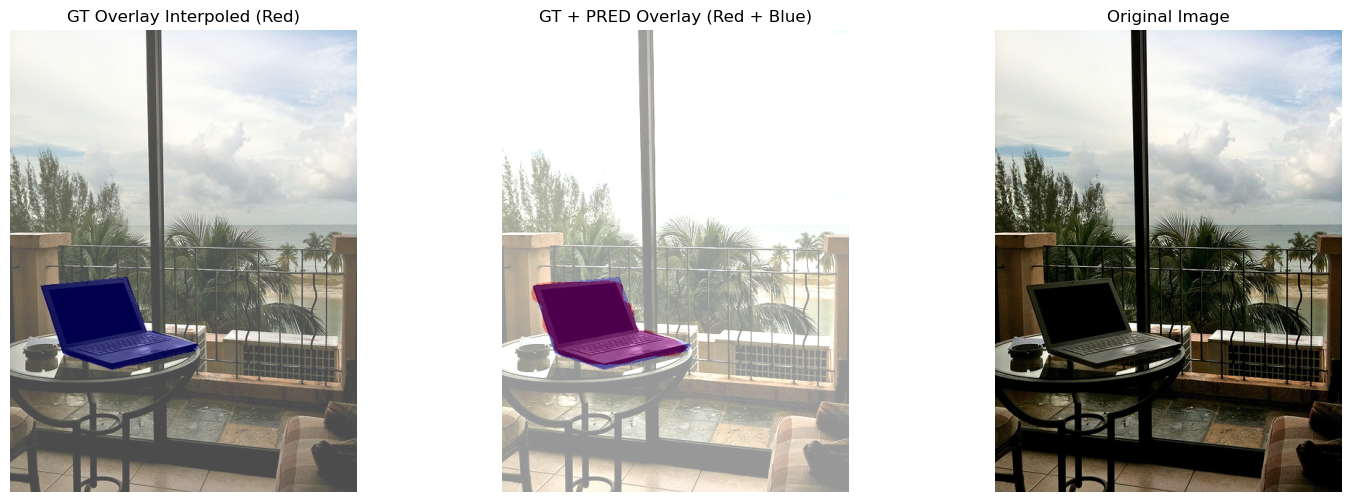

X elements:  9
Y elements:  193
La distanza di housedorf fra Gt e Predicted è  41.7612260356422
La distanza di housedorf fra Gt e Predicted in percentuale è  8.885367241626001 %


In [8]:
insieme_gt = pixel_gt[1]["pixels"][0]
insieme_predicted = pixel_predicted[0]["pixels"]
draw_mask(image_folder+image_filenames, insieme_gt, insieme_predicted)

print("X elements: ", len(insieme_gt))
print("Y elements: ", len(insieme_predicted))
distance, percentage_distance = housdorff_distance(insieme_gt,insieme_predicted)
print("La distanza di housedorf fra Gt e Predicted è ", distance)
print("La distanza di housedorf fra Gt e Predicted in percentuale è ", percentage_distance,"%")